# EXP1

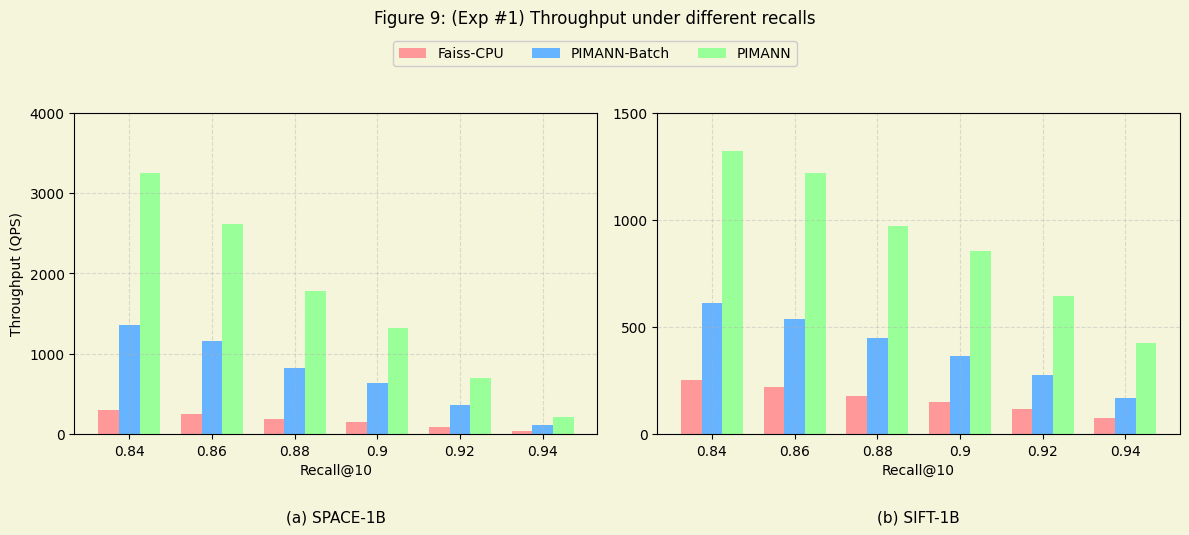

In [101]:
import matplotlib.pyplot as plt
import numpy as np

def load_exp1_data(filename):
    data = {
        'SIFT': {'DPU': {}, 'Batch DPU': {}, 'CPU': {}},
        'SPACE': {'DPU': {}, 'Batch DPU': {}, 'CPU': {}}
    }
    
    # nprobe到Recall@10的精确映射
    recall_map = {
        'SIFT': {6:0.84, 7:0.86, 9:0.88, 11:0.90, 15:0.92, 24:0.94},
        'SPACE': {4:0.84, 5:0.86, 8:0.88, 11:0.90, 21:0.92, 71:0.94}
    }

    with open(filename, 'r') as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
                
            parts = [p.strip() for p in line.split(',')]
            dataset = parts[0]
            method = parts[1]
            nprobe = int(parts[2].split('=')[1])
            qps = float(parts[3].split('=')[1])
            
            recall = recall_map[dataset][nprobe]
            data[dataset][method][recall] = qps
    
    return data

def calculate_y_axis_limits(data, dataset):
    """计算给定数据集的Y轴范围"""
    max_qps = max([max(data[dataset][method].values()) for method in data[dataset]])
    y_max = np.ceil(max_qps * 1.1)  # 增加10%余量
    
    # 自动计算合适的刻度间隔
    if y_max <= 2000:
        step = 500
    elif y_max <= 5000:
        step = 1000
    elif y_max <= 10000:
        step = 2000
    else:
        step = 5000
    
    y_ticks = np.arange(0, y_max + step, step)
    return y_max, y_ticks

def plot_figure9(data):
    """精确复现Figure 9的绘图函数"""
    # 样式设置（完全匹配原图）
    plt.style.use('default')
    plt.rcParams.update({
        'font.family': 'sans-serif',
        'font.sans-serif': ['DejaVu Sans', 'Liberation Sans'],
        'font.size': 10,
        'axes.grid': True,
        'grid.linestyle': '--',
        'grid.alpha': 0.4,
        'axes.facecolor': '#f5f5dc',
        'figure.facecolor': '#f5f5dc'
    })

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # 共用参数
    recalls = [0.84, 0.86, 0.88, 0.90, 0.92, 0.94]
    bar_width = 0.25
    x = np.arange(len(recalls))
    colors = {
        'CPU': '#ff9999',      # Faiss-CPU (粉色)
        'Batch DPU': '#66b3ff', # PIMANN-Batch (蓝色)
        'DPU': '#99ff99'        # PIMANN (绿色)
    }
    labels = {
        'CPU': 'Faiss-CPU',
        'Batch DPU': 'PIMANN-Batch',
        'DPU': 'PIMANN'
    }
    
    # ===== 子图(a): SPACE-1B =====
    space_y_max, space_y_ticks = calculate_y_axis_limits(data, 'SPACE')
    for i, method in enumerate(['CPU', 'Batch DPU', 'DPU']):
        qps = [data['SPACE'][method][r] for r in recalls]
        ax1.bar(x + i*bar_width, qps, width=bar_width, 
                color=colors[method], 
                label=labels[method])
    
    ax1.set_title('(a) SPACE-1B', y=-0.3, fontsize=11)
    ax1.set_xticks(x + bar_width)
    ax1.set_xticklabels(recalls)
    ax1.set_ylim(0, space_y_max)
    ax1.set_yticks(space_y_ticks)
    ax1.set_ylabel('Throughput (QPS)', fontsize=10)
    ax1.set_xlabel('Recall@10', fontsize=10)
    
    # ===== 子图(b): SIFT-1B =====
    sift_y_max, sift_y_ticks = calculate_y_axis_limits(data, 'SIFT')
    for i, method in enumerate(['CPU', 'Batch DPU', 'DPU']):
        qps = [data['SIFT'][method][r] for r in recalls]
        ax2.bar(x + i*bar_width, qps, width=bar_width, 
                color=colors[method],
                label=labels[method])
    
    ax2.set_title('(b) SIFT-1B', y=-0.3, fontsize=11)
    ax2.set_xticks(x + bar_width)
    ax2.set_xticklabels(recalls)
    ax2.set_ylim(0, sift_y_max)
    ax2.set_yticks(sift_y_ticks)
    ax2.set_xlabel('Recall@10', fontsize=10)
    
    # 共享图例（精确匹配原图位置和样式）
    handles, labels = ax1.get_legend_handles_labels()
    fig.legend(handles, labels, 
               loc='upper center', 
               ncol=3, 
               bbox_to_anchor=(0.5, 1.05),
               framealpha=1,
               fontsize=10)
    
    # 主标题（完全匹配原图文字）
    fig.suptitle('Figure 9: (Exp #1) Throughput under different recalls',
                 y=1.1, fontsize=12)

    plt.tight_layout()
    plt.savefig('figure9_throughput.png', dpi=300, bbox_inches='tight')
    plt.show()

# 主程序
if __name__ == '__main__':
    # 读取数据
    data = load_exp1_data('../exp1.txt')
    
    # 绘制图表
    plot_figure9(data)

# EXP2

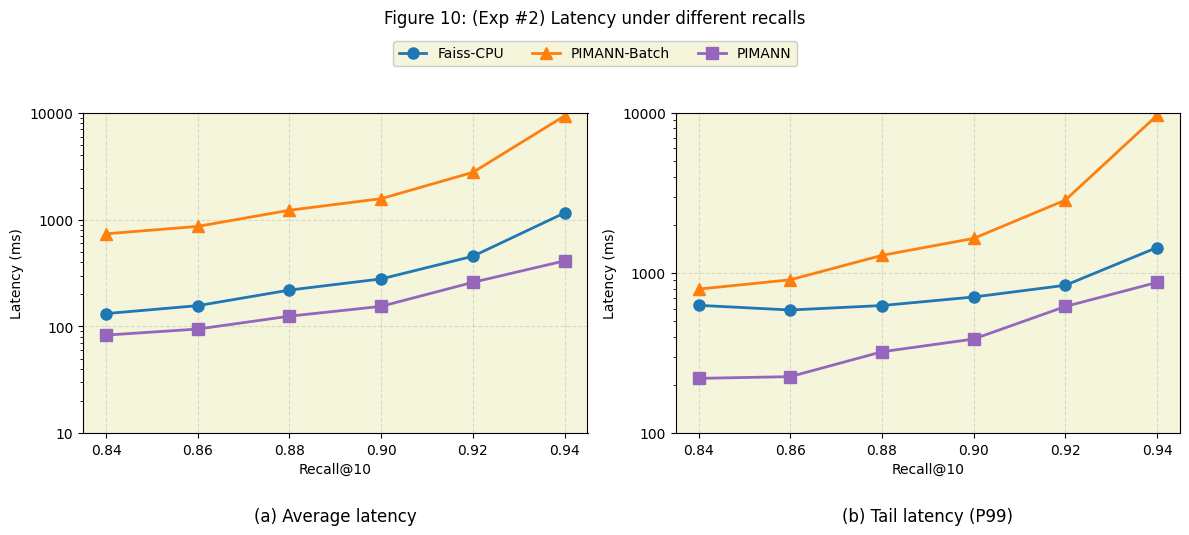

In [102]:
import matplotlib.pyplot as plt
import numpy as np

def load_exp2_data(filename):
    data = {
        'average_latency': {'DPU': {}, 'Batch DPU': {}, 'CPU': {}},
        'tail_latency': {'DPU': {}, 'Batch DPU': {}, 'CPU': {}}
    }
    
    # nprobe到Recall@10的映射（SPACE数据集）
    recall_map = {4:0.84, 5:0.86, 8:0.88, 11:0.90, 21:0.92, 71:0.94}

    with open(filename, 'r') as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
                
            parts = [p.strip() for p in line.split(',')]
            method = parts[0]
            nprobe = int(parts[1].split('=')[1])
            avg_lat = float(parts[2].split('=')[1])
            tail_lat = float(parts[3].split('=')[1])
            
            recall = recall_map[nprobe]
            data['average_latency'][method][recall] = avg_lat
            data['tail_latency'][method][recall] = tail_lat
    
    return data

def calculate_log_scale_limits(data_dict):
    """计算对数坐标下的Y轴范围"""
    all_values = []
    for method in data_dict.values():
        all_values.extend(method.values())
    
    min_val = min(all_values)
    max_val = max(all_values)
    
    # 计算对数尺度下的范围
    log_min = np.floor(np.log10(min_val))
    log_max = np.ceil(np.log10(max_val))
    
    y_min = 10**log_min
    y_max = 10**log_max
    
    # 生成对数刻度
    y_ticks = [10**i for i in range(int(log_min), int(log_max)+1)]
    
    return y_min, y_max, y_ticks

def plot_figure10(data):
    """绘制Figure 10（延迟对比图）"""
    # 样式设置（匹配原图）
    plt.style.use('default')
    plt.rcParams.update({
        'font.family': 'sans-serif',
        'font.size': 10,
        'axes.grid': True,
        'grid.linestyle': '--',
        'grid.alpha': 0.4,
        'axes.facecolor': '#f5f5dc'
    })

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # 共用参数
    recalls = [0.84, 0.86, 0.88, 0.90, 0.92, 0.94]
    markers = {
        'CPU': ('o', '#1f77b4'),    # 蓝色圆圈
        'Batch DPU': ('^', '#ff7f0e'), # 橙色三角
        'DPU': ('s', '#9467bd')       # 紫色方块
    }
    
    # 计算Y轴范围
    avg_min, avg_max, avg_ticks = calculate_log_scale_limits(data['average_latency'])
    tail_min, tail_max, tail_ticks = calculate_log_scale_limits(data['tail_latency'])
    
    # ===== 子图(a): 平均延迟 =====
    for method, (marker, color) in markers.items():
        latencies = [data['average_latency'][method][r] for r in recalls]
        ax1.plot(recalls, latencies, 
                marker=marker, color=color, 
                label='Faiss-CPU' if method == 'CPU' else f'PIMANN{"-Batch" if "Batch" in method else ""}',
                markersize=8, linewidth=2)
    
    ax1.set_title('(a) Average latency', y=-0.3)
    ax1.set_xlabel('Recall@10')
    ax1.set_ylabel('Latency (ms)')
    ax1.set_yscale('log')
    ax1.set_ylim(avg_min, avg_max)
    ax1.set_yticks(avg_ticks)
    ax1.set_yticklabels([f"{x:.1f}" if x < 1 else f"{int(x)}" for x in avg_ticks])
    
    # ===== 子图(b): 尾部延迟(P99) =====
    for method, (marker, color) in markers.items():
        latencies = [data['tail_latency'][method][r] for r in recalls]
        ax2.plot(recalls, latencies, 
                marker=marker, color=color, 
                label='Faiss-CPU' if method == 'CPU' else f'PIMANN{"-Batch" if "Batch" in method else ""}',
                markersize=8, linewidth=2)
    
    ax2.set_title('(b) Tail latency (P99)', y=-0.3)
    ax2.set_xlabel('Recall@10')
    ax2.set_ylabel('Latency (ms)')
    ax2.set_yscale('log')
    ax2.set_ylim(tail_min, tail_max)
    ax2.set_yticks(tail_ticks)
    ax2.set_yticklabels([f"{x:.1f}" if x < 1 else f"{int(x)}" for x in tail_ticks])
    
    # 共享图例
    handles, labels = ax1.get_legend_handles_labels()
    fig.legend(handles, labels, 
               loc='upper center', 
               ncol=3, 
               bbox_to_anchor=(0.5, 1.05),
               framealpha=1)
    
    # 主标题
    fig.suptitle('Figure 10: (Exp #2) Latency under different recalls',
                 y=1.1, fontsize=12)

    plt.tight_layout()
    plt.savefig('figure10_latency.png', dpi=300, bbox_inches='tight')
    plt.show()

# 主程序
if __name__ == '__main__':
    # 读取数据
    data = load_exp2_data('../exp2.txt')
    
    # 绘制图表
    plot_figure10(data)

# EXP3-fig11

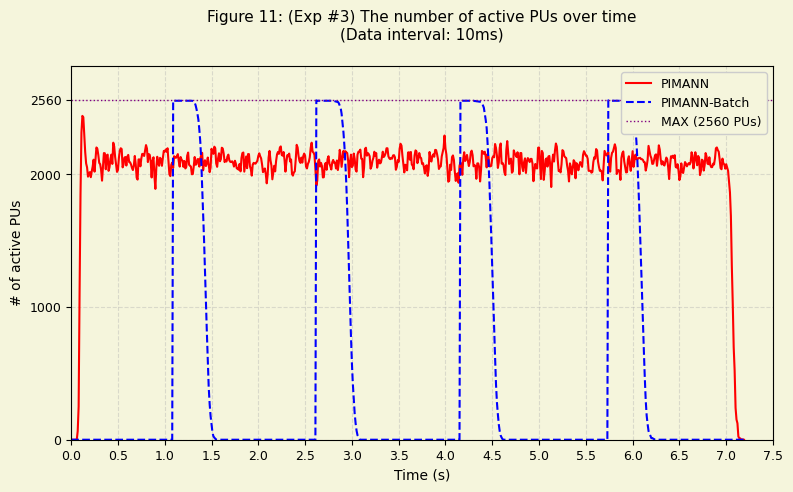

In [103]:
import matplotlib.pyplot as plt
import numpy as np

def load_exp3_data(filename):
    dpu = []
    batch_dpu = []
    
    with open(filename, 'r') as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
                
            parts = [p.strip() for p in line.split(',')]
            dpu_val = int(parts[0].split('=')[1])
            batch_val = int(parts[1].split('=')[1])
            
            dpu.append(dpu_val)
            batch_dpu.append(batch_val)
    
    # 生成时间轴（10ms间隔）
    time = np.arange(len(dpu)) * 0.01  # 转换为秒
    
    return time, dpu, batch_dpu

def plot_figure11(time, dpu, batch_dpu):
    """绘制Figure 11（精确10ms时间轴）"""
    # 样式设置
    plt.style.use('default')
    plt.rcParams.update({
        'font.family': 'sans-serif',
        'font.sans-serif': ['DejaVu Sans', 'Liberation Sans'],
        'font.size': 9,
        'axes.grid': True,
        'grid.linestyle': '--',
        'grid.alpha': 0.4,
        'axes.facecolor': '#f5f5dc',
        'figure.facecolor': '#f5f5dc'
    })

    fig, ax = plt.subplots(figsize=(8, 5))
    
    # 绘制曲线（精确匹配原图样式）
    ax.plot(time, dpu, 'r-', label='PIMANN', linewidth=1.5)
    ax.plot(time, batch_dpu, 'b--', label='PIMANN-Batch', linewidth=1.5)
    
    # 添加最大值线（紫色虚线）
    # max_pus = max(max(dpu), max(batch_dpu))
    max_pus = 2560
    ax.axhline(y=max_pus, color='purple', linestyle=':', linewidth=1, label=f'MAX ({max_pus} PUs)')
    
    # 坐标轴设置（精确到10ms）
    ax.set_xlabel('Time (s)', fontsize=10)
    ax.set_ylabel('# of active PUs', fontsize=10)
    ax.set_ylim(0, max_pus * 1.1)
    ax.set_yticks([0, 1000, 2000, max_pus])
    
    # 根据数据总时长动态设置x轴
    total_time = time[-1]
    ax.set_xlim(0, total_time)
    ax.set_xticks(np.arange(0, total_time + 0.5, 0.5))  # 每0.5秒一个刻度
    
    # 图例和标题
    ax.legend(loc='upper right', fontsize=9, framealpha=1)
    plt.title('Figure 11: (Exp #3) The number of active PUs over time\n'
              '(Data interval: 10ms)', 
              y=1.05, fontsize=11)
    
    plt.tight_layout()
    plt.savefig('figure11_active_pus_10ms.png', dpi=300, bbox_inches='tight')
    plt.show()

# 主程序
if __name__ == '__main__':
    # 读取数据
    time, dpu, batch_dpu = load_exp3_data('../exp3-fig11.txt')
    
    # 绘制图表
    plot_figure11(time, dpu, batch_dpu)

# EXP3-fig12

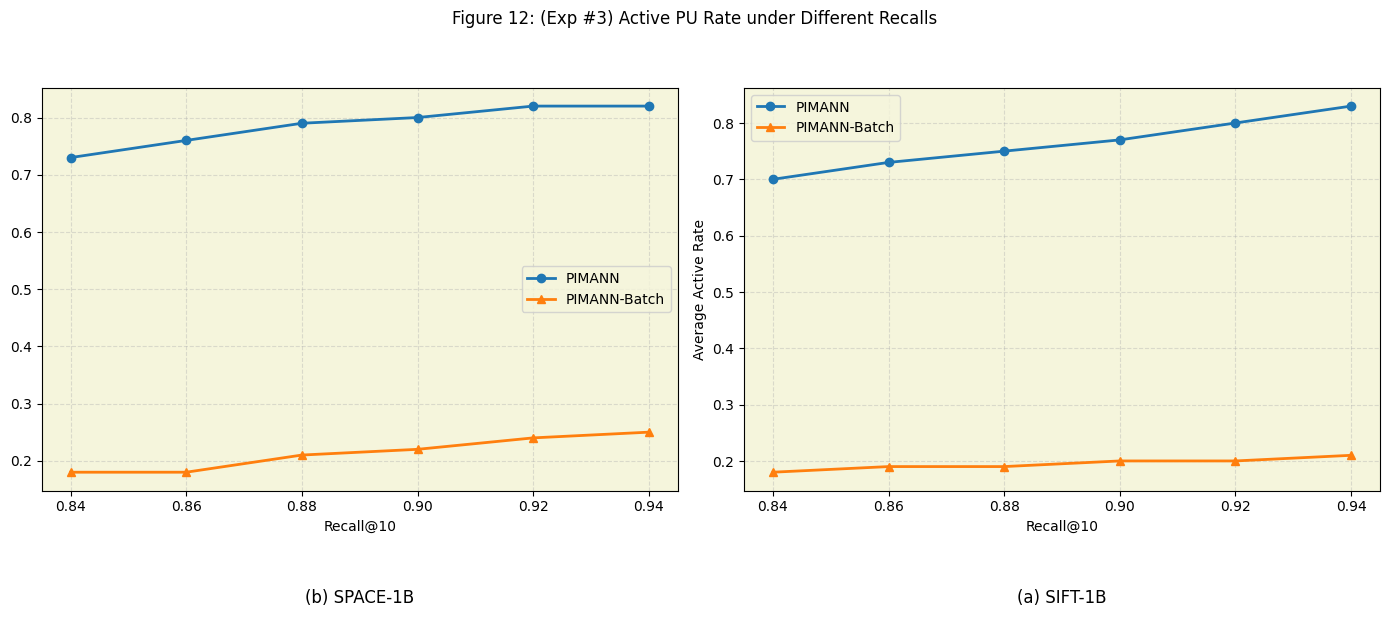

In [104]:
import matplotlib.pyplot as plt
import numpy as np

def read_data(filename):
    """读取数据并处理nprobe到Recall@10的映射"""
    data = {
        "SIFT": {"DPU": [], "Batch DPU": [], "recalls": []},
        "SPACE": {"DPU": [], "Batch DPU": [], "recalls": []}
    }
    
    # nprobe到Recall@10的映射关系（SIFT和SPACE不同）
    recall_map = {
        "SIFT": {6:0.84, 7:0.86, 9:0.88, 11:0.90, 15:0.92, 24:0.94},
        "SPACE": {4:0.84, 5:0.86, 8:0.88, 11:0.90, 21:0.92, 71:0.94}
    }

    with open(filename, 'r') as file:
        for line in file:
            line = line.strip()
            if not line:
                continue
            
            parts = [p.strip() for p in line.split(',')]
            dataset = parts[0]
            method = parts[1]
            nprobe = int(parts[2].split('=')[1])
            rate = float(parts[3].split('=')[1])
            
            recall = recall_map[dataset][nprobe]
            if recall not in data[dataset]["recalls"]:
                data[dataset]["recalls"].append(recall)
            
            if method == "DPU":
                data[dataset]["DPU"].append(rate)
            elif method == "Batch DPU":
                data[dataset]["Batch DPU"].append(rate)
    
    # 确保数据按recall排序
    for dataset in data:
        sorted_indices = np.argsort(data[dataset]["recalls"])
        data[dataset]["recalls"] = np.array(data[dataset]["recalls"])[sorted_indices].tolist()
        data[dataset]["DPU"] = np.array(data[dataset]["DPU"])[sorted_indices].tolist()
        data[dataset]["Batch DPU"] = np.array(data[dataset]["Batch DPU"])[sorted_indices].tolist()
    
    return data

def plot_figure12(data):
    """绘制Figure 12（带样式优化）"""
    plt.style.use('default')
    plt.rcParams.update({
        'font.family': 'sans-serif',
        'font.size': 10,
        'axes.grid': True,
        'grid.linestyle': '--',
        'grid.alpha': 0.4,
        'axes.facecolor': '#f5f5dc'
    })

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    
    
    # ===== SPACE Dataset =====
    ax1.plot(data["SPACE"]["recalls"], data["SPACE"]["DPU"], 
             marker='o', color='#1f77b4', label='PIMANN', linewidth=2)
    ax1.plot(data["SPACE"]["recalls"], data["SPACE"]["Batch DPU"], 
             marker='^', color='#ff7f0e', label='PIMANN-Batch', linewidth=2)
    
    ax1.set_title('(b) SPACE-1B', y=-0.3)
    ax1.set_xlabel('Recall@10')
    ax1.set_xticks(data["SPACE"]["recalls"])
    ax1.grid(True, linestyle='--', alpha=0.4)
    ax1.legend()
    
    
    # ===== SIFT Dataset =====
    ax2.plot(data["SIFT"]["recalls"], data["SIFT"]["DPU"], 
             marker='o', color='#1f77b4', label='PIMANN', linewidth=2)
    ax2.plot(data["SIFT"]["recalls"], data["SIFT"]["Batch DPU"], 
             marker='^', color='#ff7f0e', label='PIMANN-Batch', linewidth=2)
    
    ax2.set_title('(a) SIFT-1B', y=-0.3)
    ax2.set_xlabel('Recall@10')
    ax2.set_ylabel('Average Active Rate')
    ax2.set_xticks(data["SIFT"]["recalls"])
    ax2.grid(True, linestyle='--', alpha=0.4)
    ax2.legend()
    
    # 主标题
    fig.suptitle('Figure 12: (Exp #3) Active PU Rate under Different Recalls', 
                 y=1.05, fontsize=12)
    
    plt.tight_layout()
    plt.savefig('figure12_active_rate.png', dpi=300, bbox_inches='tight')
    plt.show()

# 主程序
if __name__ == '__main__':
    data = read_data("../exp3-fig12.txt")
    plot_figure12(data)

# EXP4

/tmp/ipykernel_1548897/812629069.py:95: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


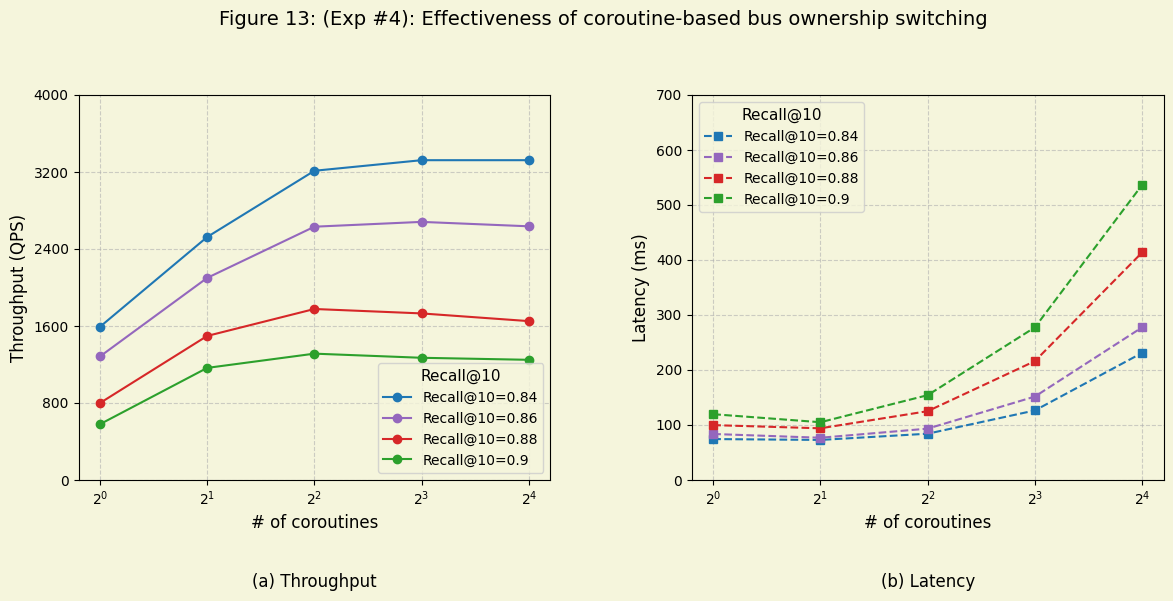

In [105]:
import matplotlib.pyplot as plt
import numpy as np

def read_exp4_data(filename):
    data = {}
    recall_map = {4: 0.84, 5: 0.86, 8: 0.88, 11: 0.90}  # nprobe到Recall@10的映射
    
    with open(filename, 'r') as f:
        for line in f:
            if not line.strip():
                continue
            parts = [p.strip() for p in line.split(',')]
            coroutines = int(parts[1].split('=')[1])
            nprobe = int(parts[2].split('=')[1])
            qps = float(parts[3].split('=')[1])
            latency = float(parts[4].split('=')[1])
            
            recall = recall_map[nprobe]
            if recall not in data:
                data[recall] = {'coroutines': [], 'qps': [], 'latency': []}
            data[recall]['coroutines'].append(coroutines)
            data[recall]['qps'].append(qps)
            data[recall]['latency'].append(latency)
    return data

def get_y_axis_limits(values):
    """根据数据自动计算Y轴范围"""
    max_val = max(max(vals) for vals in values)
    upper_limit = max_val * 1.2  # 增加20%的余量
    step = round(upper_limit / 5, -2)  # 分成5个主要刻度
    return 0, upper_limit, np.arange(0, upper_limit + step, step)

# 修改后的绘图设置（不使用seaborn样式）
plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['DejaVu Sans', 'Arial'],
    'axes.grid': True,
    'grid.linestyle': '--',
    'grid.alpha': 0.6,
    'axes.facecolor': '#f5f5dc',  # 浅米色背景
    'figure.facecolor': '#f5f5dc'
})

# 颜色设置（蓝、紫、红、绿）
colors = ['#1f77b4', '#9467bd', '#d62728', '#2ca02c']

# 创建图表
fig = plt.figure(figsize=(14, 5))
gs = fig.add_gridspec(1, 2, wspace=0.3)
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])

# 设置图表标题
fig.suptitle('Figure 13: (Exp #4): Effectiveness of coroutine-based bus ownership switching',
             y=1.05, fontsize=14)

# 读取数据
data = read_exp4_data('../exp4.txt')

# 自动计算Y轴范围
qps_values = [vals['qps'] for vals in data.values()]
latency_values = [vals['latency'] for vals in data.values()]

qps_min, qps_max, qps_ticks = get_y_axis_limits(qps_values)
latency_min, latency_max, latency_ticks = get_y_axis_limits(latency_values)

# 绘制吞吐量(QPS)图表
for i, (recall, vals) in enumerate(sorted(data.items())):
    ax1.plot(vals['coroutines'], vals['qps'], 
             marker='o', linestyle='-', color=colors[i],
             label=f'Recall@10={recall}')
ax1.set_xlabel('# of coroutines', fontsize=12)
ax1.set_ylabel('Throughput (QPS)', fontsize=12)
ax1.set_xticks([1, 2, 4, 8, 16])
ax1.set_xscale('log', base=2)
ax1.set_ylim(qps_min, qps_max)
ax1.set_yticks(qps_ticks)
ax1.legend(title='Recall@10', fontsize=10, title_fontsize=11)
ax1.set_title('(a) Throughput', y=-0.3)

# 绘制延迟(Latency)图表
for i, (recall, vals) in enumerate(sorted(data.items())):
    ax2.plot(vals['coroutines'], vals['latency'], 
             marker='s', linestyle='--', color=colors[i],
             label=f'Recall@10={recall}')
ax2.set_xlabel('# of coroutines', fontsize=12)
ax2.set_ylabel('Latency (ms)', fontsize=12)
ax2.set_xticks([1, 2, 4, 8, 16])
ax2.set_xscale('log', base=2)
ax2.set_ylim(latency_min, latency_max)
ax2.set_yticks(latency_ticks)
ax2.legend(title='Recall@10', fontsize=10, title_fontsize=11)
ax2.set_title('(b) Latency', y=-0.3)

plt.tight_layout()
plt.savefig('figure13_coroutine_performance.png', dpi=300, bbox_inches='tight', facecolor='#f5f5dc')
plt.show()

# EXP5

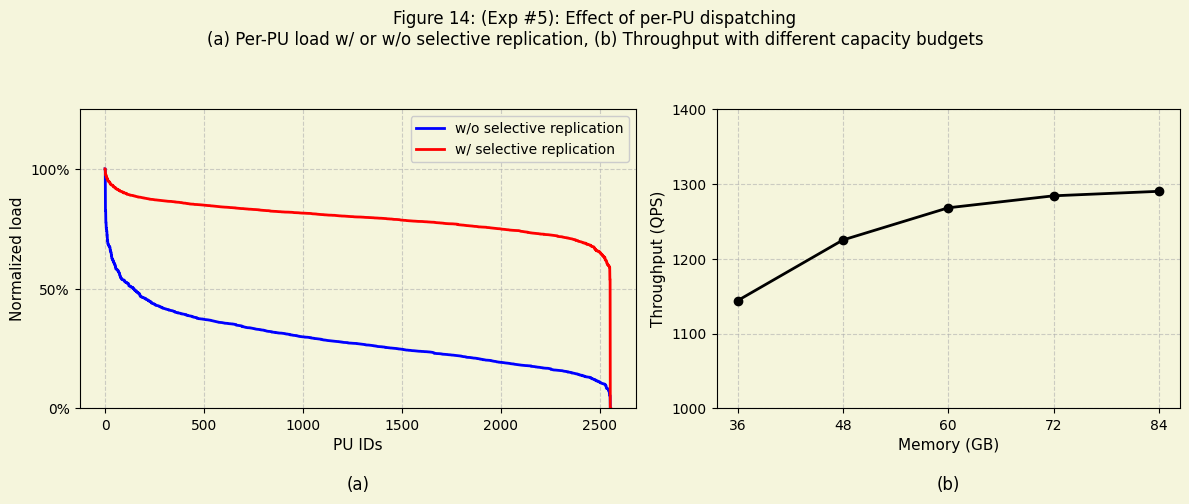

In [106]:
import matplotlib.pyplot as plt
import numpy as np

# ====================== 子图(a) Per-PU负载 ======================
def load_pu_data(wo_file, w_file):
    """读取PU负载数据（跳过空行）"""
    with open(wo_file) as f:
        wo_data = [float(line.strip()) for line in f if line.strip()]
    with open(w_file) as f:
        w_data = [float(line.strip()) for line in f if line.strip()]
    return wo_data, w_data

# ====================== 子图(b) 吞吐量 ======================
def load_throughput_data(filename):
    """读取吞吐量数据（跳过标题行）"""
    copy_rates, qps = [], []
    with open(filename) as f:
        for line in f:
            if line.startswith('COPY_RATE'):  # 跳过标题行
                continue
            if ',' in line:
                parts = line.strip().split(',')
                if len(parts) == 2:
                    copy_rates.append(float(parts[0]))
                    qps.append(float(parts[1]))
    return copy_rates, qps

# 读取数据（请确保文件路径正确）
try:
    # 子图(a)数据
    wo_load, w_load = load_pu_data('../exp5a-wo.txt', '../exp5a-w.txt')
    pu_ids = range(len(wo_load))
    
    # 子图(b)数据
    copy_rates, throughput = load_throughput_data('../exp5b.txt')
    mem_gb = [36, 48, 60, 72, 84]  # 内存容量预算
    
except FileNotFoundError as e:
    print(f"文件未找到: {e}")
    exit()
except ValueError as e:
    print(f"数据格式错误: {e}")
    exit()

# ====================== 绘图设置 ======================
plt.style.use('default')
plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.size': 10,
    'axes.grid': True,
    'grid.linestyle': '--',
    'grid.alpha': 0.6,
    'axes.facecolor': '#f5f5dc'
})

fig = plt.figure(figsize=(12, 5), facecolor='#f5f5dc')
gs = fig.add_gridspec(1, 2, width_ratios=[1.2, 1])

# ====================== 子图(a) ======================
ax1 = fig.add_subplot(gs[0])
ax1.plot(pu_ids, wo_load, 'b-', label='w/o selective replication', linewidth=2)
ax1.plot(pu_ids, w_load, 'r-', label='w/ selective replication', linewidth=2)

ax1.set_xlabel('PU IDs', fontsize=11)
ax1.set_ylabel('Normalized load', fontsize=11)
ax1.set_ylim(0, 1.25)
ax1.set_yticks([0, 0.5, 1.0], ['0%', '50%', '100%'])
ax1.legend(loc='upper right', framealpha=1)
ax1.set_title('(a)', y=-0.3, fontsize=12)

# ====================== 子图(b) ======================
ax2 = fig.add_subplot(gs[1])
ax2.plot(mem_gb, throughput, 'ko-', markersize=6, linewidth=2)

ax2.set_xlabel('Memory (GB)', fontsize=11)
ax2.set_ylabel('Throughput (QPS)', fontsize=11)
ax2.set_xticks(mem_gb)
# ax2.set_yticks(range(1000, 6000, 1000))
ax2.set_yticks(range(1000, 1500, 100))
ax2.set_title('(b)', y=-0.3, fontsize=12)

# ====================== 主标题和保存 ======================
plt.suptitle('Figure 14: (Exp #5): Effect of per-PU dispatching\n'
             '(a) Per-PU load w/ or w/o selective replication, '
             '(b) Throughput with different capacity budgets', 
             y=1.05, fontsize=12)

plt.tight_layout()
plt.savefig('figure14_per_pu_dispatching.png', dpi=300, bbox_inches='tight', facecolor='#f5f5dc')
plt.show()

# EXP6

/tmp/ipykernel_1548897/3102970650.py:136: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


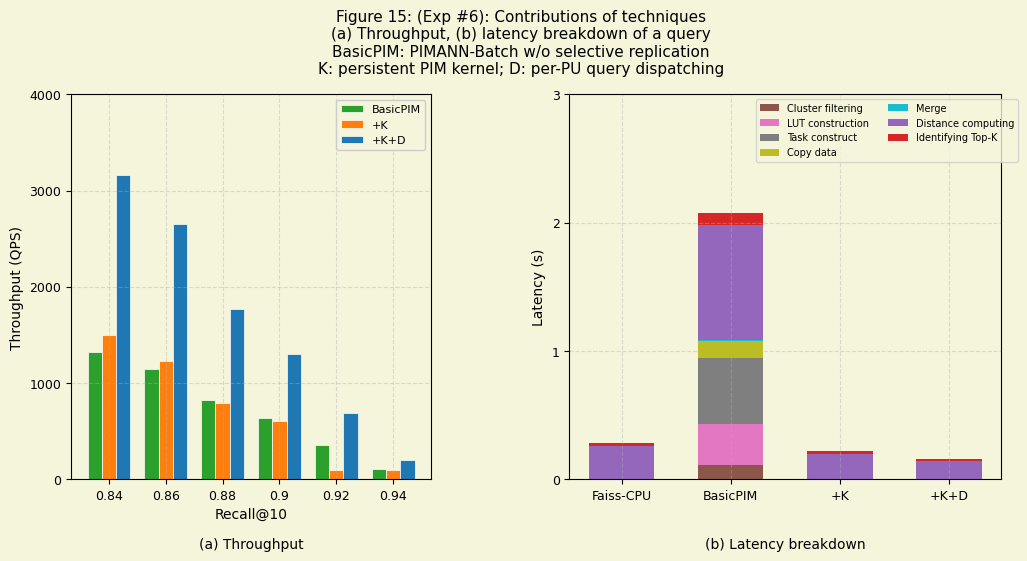

In [107]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import font_manager

def set_font():
    """设置可用的字体替代Arial"""
    try:
        # 尝试查找Arial，失败后使用默认字体
        font_manager.findfont('Arial', fallback_to_default=False)
        plt.rcParams['font.family'] = 'Arial'
    except:
        plt.rcParams['font.family'] = 'sans-serif'
        plt.rcParams['font.sans-serif'] = ['DejaVu Sans', 'Liberation Sans', 'Helvetica']

def load_exp6_data(filename):
    throughput = {'BasicPIM': [], '+K': [], '+K+D': []}
    latency = {'Faiss-CPU': [], 'BasicPIM': [], '+K': [], '+K+D': []}
    current_section = None
    recall_map = {4:0.84, 5:0.86, 8:0.88, 11:0.90, 21:0.92, 71:0.94}

    with open(filename, 'r') as f:
        for line in f:
            line = line.strip()
            if not line: continue
                
            if line.startswith('latency breakdown:'):
                current_section = 'latency'
                continue
                
            if current_section == 'latency':
                parts = [x.strip() for x in line.split(',')]
                if 'CPU' in line:
                    latency['Faiss-CPU'] = [float(x) for x in parts[1:8]]
                elif 'Batch DPU' in line:
                    latency['BasicPIM'] = [float(x) for x in parts[1:8]]
                elif 'DPU, ENABLE_REPLICA=0' in line:
                    latency['+K'] = [float(x) for x in parts[2:9]]
                elif 'DPU, ENABLE_REPLICA=1' in line:
                    latency['+K+D'] = [float(x) for x in parts[2:9]]
            else:
                parts = [x.strip() for x in line.split(',')]
                if 'Batch DPU' in line:
                    nprobe = int(parts[1].split('=')[1])
                    throughput['BasicPIM'].append((recall_map[nprobe], float(parts[2].split('=')[1])))
                elif 'DPU, ENABLE_REPLICA=0' in line:
                    nprobe = int(parts[2].split('=')[1])
                    throughput['+K'].append((recall_map[nprobe], float(parts[3].split('=')[1])))
                elif 'DPU, ENABLE_REPLICA=1' in line:
                    nprobe = int(parts[2].split('=')[1])
                    throughput['+K+D'].append((recall_map[nprobe], float(parts[3].split('=')[1])))
    
    # 排序数据
    for tech in throughput:
        throughput[tech] = sorted(throughput[tech], key=lambda x: x[0])
        throughput[tech] = {'recall': [x[0] for x in throughput[tech]], 
                          'qps': [x[1] for x in throughput[tech]]}
    
    return throughput, latency

def plot_figure15(throughput, latency):
    """精确复现Figure 15的绘图"""
    # 设置字体
    set_font()
    
    # 样式设置
    plt.style.use('default')
    plt.rcParams.update({
        'font.size': 9,
        'axes.grid': True,
        'grid.linestyle': '--',
        'grid.alpha': 0.4,
        'axes.facecolor': '#f5f5dc',
        'figure.facecolor': '#f5f5dc'
    })

    fig = plt.figure(figsize=(12, 5))
    gs = fig.add_gridspec(1, 2, width_ratios=[1, 1.2], wspace=0.35)

    # ===== 子图(a): 吞吐量 =====
    ax1 = fig.add_subplot(gs[0])
    recall = throughput['BasicPIM']['recall']
    bar_width = 0.25
    x = np.arange(len(recall))
    colors = ['#2ca02c', '#ff7f0e', '#1f77b4']  # 绿-橙-蓝
    
    for i, tech in enumerate(['BasicPIM', '+K', '+K+D']):
        ax1.bar(x + i*bar_width, throughput[tech]['qps'],
                width=bar_width, color=colors[i], label=tech,
                edgecolor='white', linewidth=0.5)
    
    ax1.set_xlabel('Recall@10', fontsize=10)
    ax1.set_ylabel('Throughput (QPS)', fontsize=10)
    ax1.set_xticks(x + bar_width)
    ax1.set_xticklabels(recall)
    ax1.set_ylim(0, 4000)
    ax1.set_yticks(range(0, 4001, 1000))
    ax1.legend(fontsize=8, framealpha=1)
    ax1.set_title('(a) Throughput', y=-0.2, fontsize=10)

    # ===== 子图(b): 延迟分解 =====
    ax2 = fig.add_subplot(gs[1])
    latency_colors = [
        '#8c564b', '#e377c2', '#7f7f7f', 
        '#bcbd22', '#17becf', '#9467bd', '#d62728'
    ]
    latency_labels = [
        'Cluster filtering', 'LUT construction', 'Task construct',
        'Copy data', 'Merge', 'Distance computing', 'Identifying Top-K'
    ]
    
    # 计算总延迟
    total_latency = {tech: sum(x/1000 for x in vals) for tech, vals in latency.items()}
    y_max = np.ceil(max(total_latency.values()) * 1.1)
    
    # 绘制堆叠柱状图
    bottom = np.zeros(4)
    for i, (color, label) in enumerate(zip(latency_colors, latency_labels)):
        heights = [latency[tech][i]/1000 for tech in ['Faiss-CPU', 'BasicPIM', '+K', '+K+D']]
        ax2.bar(['Faiss-CPU', 'BasicPIM', '+K', '+K+D'], 
                heights, bottom=bottom, color=color, label=label, width=0.6)
        bottom += heights
    
    ax2.set_ylabel('Latency (s)', fontsize=10)
    ax2.set_ylim(0, y_max)
    ax2.set_yticks(np.arange(0, y_max + 1, max(1, int(y_max/6))))
    ax2.legend(fontsize=7, ncol=2, bbox_to_anchor=(1.05, 1))
    ax2.set_title('(b) Latency breakdown', y=-0.2, fontsize=10)

    # 主标题
    fig.suptitle('Figure 15: (Exp #6): Contributions of techniques\n'
                '(a) Throughput, (b) latency breakdown of a query\n'
                'BasicPIM: PIMANN-Batch w/o selective replication\n'
                'K: persistent PIM kernel; D: per-PU query dispatching',
                y=1.05, fontsize=11)

    plt.tight_layout()
    plt.savefig('figure15.png', dpi=300, bbox_inches='tight')
    plt.show()

# 执行绘图
throughput, latency = load_exp6_data('../exp6.txt')
plot_figure15(throughput, latency)

# EXP7

数据加载验证:
Recall@10值: [0.84, 0.86, 0.88, 0.9, 0.92, 0.94]
GPU QPS: [1279.75, 1146.0, 909.67, 629.17, 370.21, 103.32]
DPU QPS: [3205.0, 2617.0, 1780.0, 1313.0, 695.0, 203.0]
GPU QPS/W: [4.2658, 3.82, 3.0322, 2.0972, 1.234, 0.3444]
DPU QPS/W: [6.9372, 5.6645, 3.8528, 2.842, 1.5043, 0.4394]


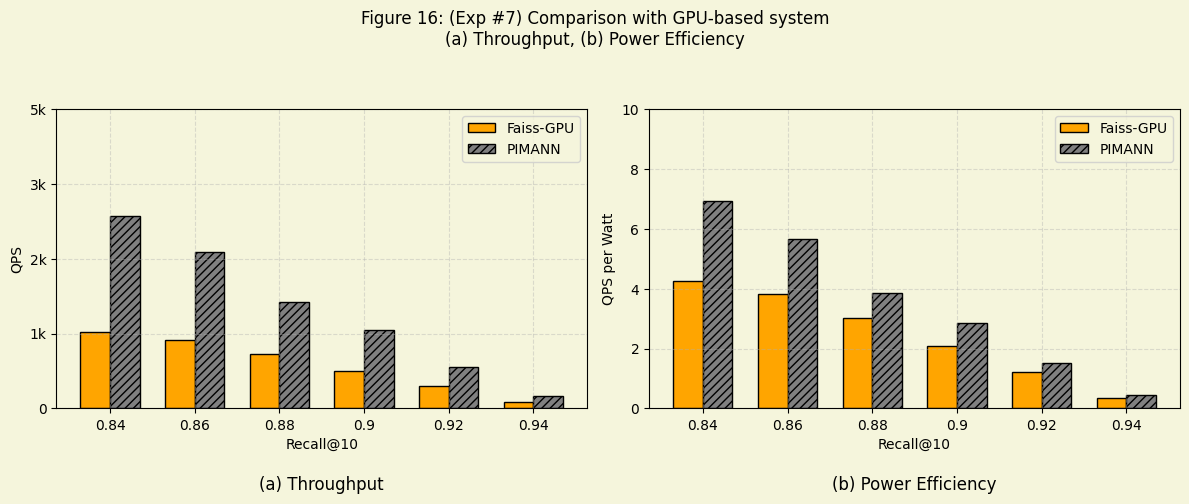

In [108]:
import matplotlib.pyplot as plt
import numpy as np

def load_exp7_data(filename):
    data = {
        'recalls': [],  # 自动填充
        'GPU': {'QPS': [], 'QPSW': []},
        'DPU': {'QPS': [], 'QPSW': []}
    }
    
    # nprobe到Recall@10的映射（SPACE数据集）
    recall_map = {4:0.84, 5:0.86, 8:0.88, 11:0.90, 21:0.92, 71:0.94}
    temp_data = {}

    with open(filename, 'r') as f:
        for line in f:
            line = line.strip()
            if not line or not line.startswith('nprobe:'):
                continue
                
            parts = [p.strip() for p in line.split(',')]
            nprobe = int(parts[0].split(':')[1])
            recall = recall_map[nprobe]
            
            # 初始化数据结构
            if recall not in temp_data:
                temp_data[recall] = {
                    'GPU': {'QPS': None, 'QPSW': None},
                    'DPU': {'QPS': None, 'QPSW': None}
                }
            
            # 解析当前行数据
            for part in parts[1:]:
                if 'DPU QPS:' in part:
                    temp_data[recall]['DPU']['QPS'] = float(part.split(':')[1])
                elif 'GPU QPS:' in part:
                    temp_data[recall]['GPU']['QPS'] = float(part.split(':')[1])
                elif 'DPU QPS per Watt:' in part:
                    temp_data[recall]['DPU']['QPSW'] = float(part.split(':')[1])
                elif 'GPU QPS per Watt:' in part:
                    temp_data[recall]['GPU']['QPSW'] = float(part.split(':')[1])
    
    # 按recall排序并填充最终数据结构
    sorted_recalls = sorted(temp_data.keys())
    data['recalls'] = sorted_recalls
    
    for recall in sorted_recalls:
        for tech in ['GPU', 'DPU']:
            data[tech]['QPS'].append(temp_data[recall][tech]['QPS'])
            data[tech]['QPSW'].append(temp_data[recall][tech]['QPSW'])
    
    return data

def plot_figure16(data):
    """精确绘制Figure 16对比图"""
    # 样式设置（完全匹配图片）
    plt.style.use('default')
    plt.rcParams.update({
        'font.family': 'sans-serif',
        'font.size': 10,
        'axes.grid': True,
        'grid.linestyle': '--',
        'grid.alpha': 0.4,
        'axes.facecolor': '#f5f5dc',
        'figure.facecolor': '#f5f5dc'
    })

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # 共用参数
    recalls = data['recalls']
    bar_width = 0.35
    x = np.arange(len(recalls))
    colors = {
        'GPU': '#FFA500',  # 橙色（Faiss-GPU）
        'DPU': '#808080'   # 灰色（PIMANN）
    }
    
    # ===== 子图(a): 吞吐量 =====
    # 自动计算y轴范围
    max_qps = max(max(data['GPU']['QPS']), max(data['DPU']['QPS']))
    y_upper = (int(max_qps / 5000) + 1) * 5000  # 向上取整到最近的10k
    
    ax1.bar(x - bar_width/2, data['GPU']['QPS'], width=bar_width,
            color=colors['GPU'], label='Faiss-GPU', edgecolor='black')
    ax1.bar(x + bar_width/2, data['DPU']['QPS'], width=bar_width,
            color=colors['DPU'], label='PIMANN', 
            hatch='////', edgecolor='black')
    
    ax1.set_title('(a) Throughput', y=-0.3)
    ax1.set_xticks(x)
    ax1.set_xticklabels(recalls)
    ax1.set_ylim(0, y_upper)
    ax1.set_yticks(np.linspace(0, y_upper, 5))  # 均匀分布5个刻度
    ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x/1000)}k' if x >= 1000 else str(int(x))))
    ax1.set_ylabel('QPS')
    ax1.set_xlabel('Recall@10')
    ax1.legend()
    
    # ===== 子图(b): 能效 =====
    # 自动计算y轴范围
    max_qpsw = max(max(data['GPU']['QPSW']), max(data['DPU']['QPSW']))
    y_upper_qpsw = (int(max_qpsw / 10) + 1) * 10  # 向上取整到最近的50
    
    ax2.bar(x - bar_width/2, data['GPU']['QPSW'], width=bar_width,
            color=colors['GPU'], label='Faiss-GPU', edgecolor='black')
    ax2.bar(x + bar_width/2, data['DPU']['QPSW'], width=bar_width,
            color=colors['DPU'], label='PIMANN',
            hatch='////', edgecolor='black')
    
    ax2.set_title('(b) Power Efficiency', y=-0.3)
    ax2.set_xticks(x)
    ax2.set_xticklabels(recalls)
    ax2.set_ylim(0, y_upper_qpsw)
    ax2.set_yticks(np.linspace(0, y_upper_qpsw, 6))  # 均匀分布6个刻度
    ax2.set_ylabel('QPS per Watt')
    ax2.set_xlabel('Recall@10')
    ax2.legend()
    
    # 主标题
    fig.suptitle('Figure 16: (Exp #7) Comparison with GPU-based system\n'
                '(a) Throughput, (b) Power Efficiency',
                y=1.05, fontsize=12)

    plt.tight_layout()
    plt.savefig('figure16_gpu_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

# 主程序
if __name__ == '__main__':
    # 读取数据
    data = load_exp7_data('../exp7.txt')
    
    # 数据验证
    print("数据加载验证:")
    print(f"Recall@10值: {data['recalls']}")
    print(f"GPU QPS: {data['GPU']['QPS']}")
    print(f"DPU QPS: {data['DPU']['QPS']}")
    print(f"GPU QPS/W: {data['GPU']['QPSW']}")
    print(f"DPU QPS/W: {data['DPU']['QPSW']}")
    
    # 绘制图表
    plot_figure16(data)

# EXP8

数据加载验证:
Faiss-CPU:
  Price: 1500
  QPS: 142.0
  QPS/$: 0.0947
Faiss-GPU:
  Price: 9685
  QPS: 629.6
  QPS/$: 0.065
PIMANN:
  Price: 5473
  QPS: 1313.0
  QPS/$: 0.2399


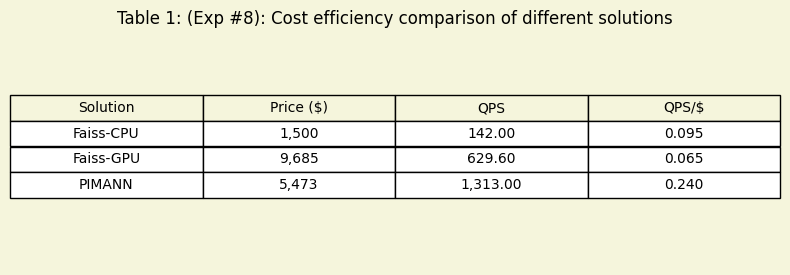

In [109]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.table import Table

def load_exp8_data(filename):
    data = {
        'Faiss-CPU': {'Price': 1500, 'QPS': None, 'QPS/$': None},
        'Faiss-GPU': {'Price': 9685, 'QPS': None, 'QPS/$': None},
        'PIMANN': {'Price': 5473, 'QPS': None, 'QPS/$': None}
    }
    
    with open(filename, 'r') as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
                
            if 'dpu_qps:' in line:
                parts = [p.strip() for p in line.split(',')]
                data['PIMANN']['QPS'] = float(parts[0].split(':')[1])
                data['PIMANN']['QPS/$'] = float(parts[1].split(':')[1])
            elif 'cpu_qps:' in line:
                parts = [p.strip() for p in line.split(',')]
                data['Faiss-CPU']['QPS'] = float(parts[0].split(':')[1])
                data['Faiss-CPU']['QPS/$'] = float(parts[1].split(':')[1])
            elif 'gpu_qps:' in line:
                parts = [p.strip() for p in line.split(',')]
                data['Faiss-GPU']['QPS'] = float(parts[0].split(':')[1])
                data['Faiss-GPU']['QPS/$'] = float(parts[1].split(':')[1])
    
    return data

def plot_table1(data):
    """绘制Table 1成本效率对比表"""
    # 样式设置（匹配图片）
    plt.style.use('default')
    plt.rcParams.update({
        'font.family': 'sans-serif',
        'font.size': 10,
        'axes.facecolor': '#f5f5dc',
        'figure.facecolor': '#f5f5dc'
    })

    fig = plt.figure(figsize=(8, 3))
    ax = fig.add_subplot(111, frame_on=False)
    ax.axis('off')
    
    # 表格数据
    solutions = ['Faiss-CPU', 'Faiss-GPU', 'PIMANN']
    columns = ['Solution', 'Price ($)', 'QPS', 'QPS/$']
    cell_text = [
        [solutions[0], f"{data[solutions[0]]['Price']:,}", 
         f"{data[solutions[0]]['QPS']:,.2f}", 
         f"{data[solutions[0]]['QPS/$']:,.3f}"],
        [solutions[1], f"{data[solutions[1]]['Price']:,}", 
         f"{data[solutions[1]]['QPS']:,.2f}", 
         f"{data[solutions[1]]['QPS/$']:,.3f}"],
        [solutions[2], f"{data[solutions[2]]['Price']:,}", 
         f"{data[solutions[2]]['QPS']:,.2f}", 
         f"{data[solutions[2]]['QPS/$']:,.3f}"]
    ]
    
    # 创建表格
    table = ax.table(cellText=cell_text,
                     colLabels=columns,
                     loc='center',
                     cellLoc='center',
                     colColours=['#f5f5dc']*4)
    
    # 样式调整
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 1.5)
    
    # 标题
    plt.suptitle('Table 1: (Exp #8): Cost efficiency comparison of different solutions',
                 y=0.9, fontsize=12)
    
    plt.tight_layout()
    plt.savefig('table1_cost_efficiency.png', dpi=300, bbox_inches='tight')
    plt.show()

# 主程序
if __name__ == '__main__':
    # 读取数据
    data = load_exp8_data('../exp8.txt')
    
    # 数据验证
    print("数据加载验证:")
    for solution in data:
        print(f"{solution}:")
        print(f"  Price: {data[solution]['Price']}")
        print(f"  QPS: {data[solution]['QPS']}")
        print(f"  QPS/$: {data[solution]['QPS/$']}")
    
    # 绘制表格
    plot_table1(data)